# **Experiment 6: Dimensionality Reduction and Model Evaluation (With and Without PCA)**

In [ ]:
# IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, make_scorer, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [ ]:
TARGET_COLUMN = 'class'

df = pd.read_csv('/content/drive/MyDrive/ml-lab/spambase_csv.csv')
print(df.head())
print("Initial shape:", df.shape)

   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_%3B  char_freq_%28  \
0             0.00            0.00  ...           0.00          0.0

In [ ]:
# HANDLE MISSING VALUES
df = df.dropna(thresh=df.shape[1]//2)  # Drop rows with >50% missing
df.fillna(df.median(numeric_only=True), inplace=True)

# OUTLIER HANDLING (Z-Score)
def remove_outliers(df, threshold=3):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    z_scores = np.abs((df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std())
    return df[(z_scores < threshold).all(axis=1)]

df = remove_outliers(df)
# print("After outlier removal:", df.shape)

In [ ]:
# FEATURE / TARGET SPLIT
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# ENCODE + STANDARDIZE
numeric_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(exclude=[np.number]).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# TRAIN / TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,          # 20% test hold-out
    stratify=y,             # keep class balance if classification
    random_state=42
)

**PCA Variance Explained**

In [ ]:
pca = PCA(n_components=0.95)
pca.fit(X_scaled)

print("Chosen components:", pca.n_components_)
print("Total variance explained (%):", pca.explained_variance_ratio_.sum()*100)


Chosen components: 49
Total variance explained (%): 95.53617010131482


**Support Vector Machine (SVM)**

SVC Performance Table
   kernel     C  gamma  Accuracy_no_PCA  Accuracy_PCA
0  linear   0.1  scale          0.93135      0.924485
1  linear  10.0  scale          0.93135      0.924485
2     rbf   0.1  scale          0.93135      0.924485
3     rbf  10.0  scale          0.93135      0.924485

Best Params (No PCA)
kernel               linear
C                       0.1
gamma                 scale
Accuracy_no_PCA     0.93135
Accuracy_PCA       0.924485
Name: 0, dtype: object


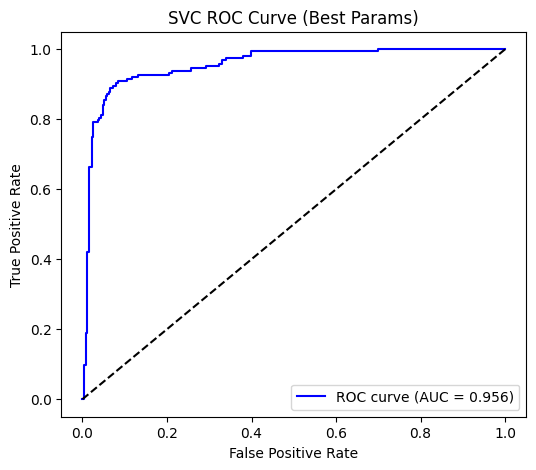

In [ ]:
# ========== HYPERPARAM GRID ==========
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 10],
    'gamma': ['scale']
}

# ========== HELPER FUNCTION ==========
def evaluate_svc(X_train, X_test, y_train, y_test, use_pca=False, pca_variance=0.95):
    if use_pca:
        pca = PCA(n_components=pca_variance)
        X_train_proc = pca.fit_transform(X_train)
        X_test_proc = pca.transform(X_test)
    else:
        X_train_proc = X_train
        X_test_proc = X_test

    svc = SVC(probability=True)
    grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')  # you can switch scoring
    grid.fit(X_train_proc, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_proc)
    y_proba = best_model.predict_proba(X_test_proc)[:,1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    return grid.best_params_, acc, auc, y_test, y_proba

# ========== EVALUATE ALL COMBOS ==========
results = []
for kernel in param_grid['kernel']:
    for C in param_grid['C']:
        for gamma in param_grid['gamma']:
            params = {'kernel': kernel, 'C': C, 'gamma': gamma}

            # No PCA
            _, acc_no_pca, auc_no_pca, y_test_val, y_proba_no_pca = evaluate_svc(
                X_train, X_test, y_train, y_test, use_pca=False
            )

            # With PCA
            _, acc_pca, auc_pca, _, y_proba_pca = evaluate_svc(
                X_train, X_test, y_train, y_test, use_pca=True, pca_variance=0.95
            )

            results.append({
                'kernel': kernel,
                'C': C,
                'gamma': gamma,
                'Accuracy_no_PCA': acc_no_pca,
                'Accuracy_PCA': acc_pca
            })

# ========== RESULTS TABLE ==========
results_df = pd.DataFrame(results)
print("SVC Performance Table")
print(results_df)

# ========== BEST MODEL ==========
best_idx = results_df['Accuracy_no_PCA'].idxmax()  # you can also pick max of PCA
best_params = results_df.iloc[best_idx]
print("\nBest Params (No PCA)")
print(best_params)

# ========== ROC CURVE FOR BEST MODEL ==========
# Using No PCA best model
best_kernel = best_params['kernel']
best_C = best_params['C']
best_gamma = best_params['gamma']

svc_best = SVC(kernel=best_kernel, C=best_C, gamma=best_gamma, probability=True)
svc_best.fit(X_train, y_train)
y_proba_best = svc_best.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = roc_auc_score(y_test, y_proba_best)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})', color='blue')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC ROC Curve (Best Params)')
plt.legend(loc='lower right')
plt.show()

**Naive Bayes**

Naive Bayes Performance Table
      smoothing  Accuracy_no_PCA  Accuracy_PCA
0  1.000000e-09         0.720824      0.832952
1  1.000000e-08         0.723112      0.832952
2  1.000000e-07         0.725400      0.832952
3  1.000000e-06         0.725400      0.832952

Best Smoothing (No PCA)
smoothing          1.000000e-07
Accuracy_no_PCA    7.254005e-01
Accuracy_PCA       8.329519e-01
Name: 2, dtype: float64


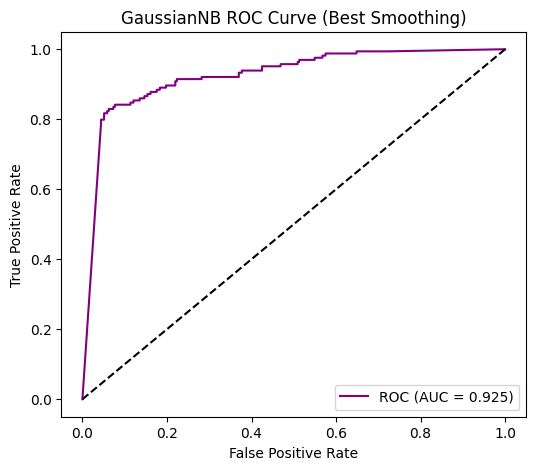

In [ ]:
# Smoothing values to test
smoothing_values = [1e-9, 1e-8, 1e-7, 1e-6]

def evaluate_nb(X_train, X_test, y_train, y_test, smoothing, use_pca=False):
    if use_pca:
        pca = PCA(n_components=0.95)
        X_train_proc = pca.fit_transform(X_train)
        X_test_proc = pca.transform(X_test)
    else:
        X_train_proc = X_train
        X_test_proc = X_test

    model = GaussianNB(var_smoothing=smoothing)
    model.fit(X_train_proc, y_train)
    y_pred = model.predict(X_test_proc)
    y_prob = model.predict_proba(X_test_proc)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    return acc, auc, y_prob

results = []
for s in smoothing_values:
    acc_no_pca, auc_no_pca, prob_no_pca = evaluate_nb(
        X_train, X_test, y_train, y_test, s, use_pca=False
    )
    acc_pca, auc_pca, prob_pca = evaluate_nb(
        X_train, X_test, y_train, y_test, s, use_pca=True
    )
    results.append({
        "smoothing": s,
        "Accuracy_no_PCA": acc_no_pca,
        "Accuracy_PCA": acc_pca
    })

results_df = pd.DataFrame(results)
print("Naive Bayes Performance Table")
print(results_df)

# --- Best Params (based on no PCA accuracy) ---
best_idx = results_df['Accuracy_no_PCA'].idxmax()
best_params = results_df.iloc[best_idx]
print("\nBest Smoothing (No PCA)")
print(best_params)

# --- ROC curve for best model ---
best_s = best_params['smoothing']
nb_best = GaussianNB(var_smoothing=best_s)
nb_best.fit(X_train, y_train)
y_proba_best = nb_best.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = roc_auc_score(y_test, y_proba_best)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})', color='purple')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GaussianNB ROC Curve (Best Smoothing)')
plt.legend(loc='lower right')
plt.show()

**K-Nearest Neighbours**

KNN Performance Table
   k   weights     metric  Accuracy_no_PCA  Accuracy_PCA
0  3   uniform  euclidean         0.899314      0.901602
1  3   uniform  manhattan         0.899314      0.897025
2  3  distance  euclidean         0.910755      0.908467
3  3  distance  manhattan         0.903890      0.906178
4  5   uniform  euclidean         0.892449      0.899314
5  5   uniform  manhattan         0.897025      0.894737
6  5  distance  euclidean         0.908467      0.910755
7  5  distance  manhattan         0.906178      0.906178

Best KNN Params (No PCA)
k                          3
weights             distance
metric             euclidean
Accuracy_no_PCA     0.910755
Accuracy_PCA        0.908467
Name: 2, dtype: object


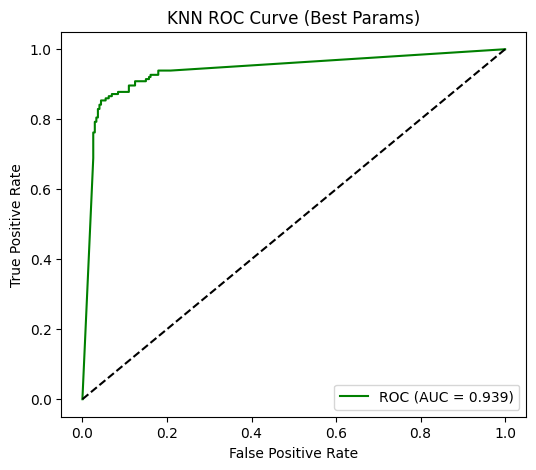

In [ ]:
# --- Hyperparam grid ---
k_values = [3, 5]
weights_options = ['uniform', 'distance']
metrics_options = ['euclidean', 'manhattan']

def evaluate_knn(X_train, X_test, y_train, y_test,
                 k, weight, metric, use_pca=False):
    if use_pca:
        pca = PCA(n_components=0.95)
        X_train_proc = pca.fit_transform(X_train)
        X_test_proc = pca.transform(X_test)
    else:
        X_train_proc, X_test_proc = X_train, X_test

    model = KNeighborsClassifier(n_neighbors=k,
                                 weights=weight,
                                 metric=metric)
    model.fit(X_train_proc, y_train)
    y_pred = model.predict(X_test_proc)
    y_prob = model.predict_proba(X_test_proc)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    return acc, auc, y_prob

results = []
for k in k_values:
    for w in weights_options:
        for m in metrics_options:
            acc_no_pca, auc_no_pca, _ = evaluate_knn(
                X_train, X_test, y_train, y_test,
                k, w, m, use_pca=False
            )
            acc_pca, auc_pca, _ = evaluate_knn(
                X_train, X_test, y_train, y_test,
                k, w, m, use_pca=True
            )
            results.append({
                "k": k,
                "weights": w,
                "metric": m,
                "Accuracy_no_PCA": acc_no_pca,
                "Accuracy_PCA": acc_pca
            })

results_df = pd.DataFrame(results)
print("KNN Performance Table")
print(results_df)

# --- Pick best based on no-PCA accuracy ---
best_idx = results_df['Accuracy_no_PCA'].idxmax()
best_params = results_df.iloc[best_idx]
print("\nBest KNN Params (No PCA)")
print(best_params)

# --- ROC curve for that best combo ---
best_k = best_params['k']
best_w = best_params['weights']
best_m = best_params['metric']

knn_best = KNeighborsClassifier(n_neighbors=best_k,
                                weights=best_w,
                                metric=best_m)
knn_best.fit(X_train, y_train)
y_proba_best = knn_best.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = roc_auc_score(y_test, y_proba_best)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})', color='green')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve (Best Params)')
plt.legend(loc='lower right')
plt.show()

**Logistic Regression**

Logistic Regression Performance Table
      C penalty  Accuracy_no_PCA  Accuracy_PCA
0  0.01      l2         0.908467      0.908467
1  0.01      l1         0.871854      0.894737
2  0.10      l2         0.903890      0.906178
3  0.10      l1         0.913043      0.917620
4  1.00      l2         0.910755      0.901602
5  1.00      l1         0.910755      0.906178

Best Logistic Regression Params (No PCA)
C                       0.1
penalty                  l1
Accuracy_no_PCA    0.913043
Accuracy_PCA        0.91762
Name: 3, dtype: object


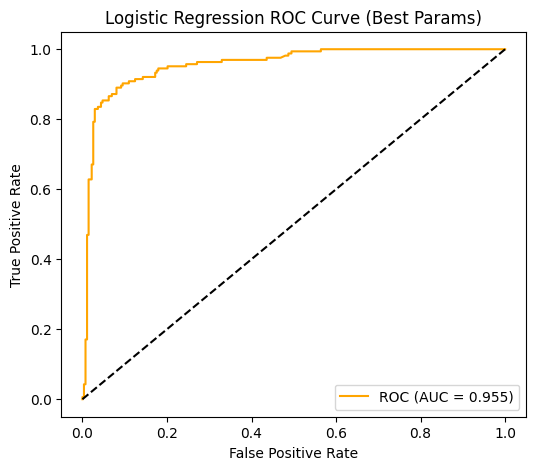

In [ ]:
# --- Hyperparam grid ---
c_values = [0.01, 0.1, 1]
penalties = ['l2', 'l1']

def evaluate_logreg(X_train, X_test, y_train, y_test,
                    c_val, penalty, use_pca=False):
    if use_pca:
        pca = PCA(n_components=0.95)
        X_train_proc = pca.fit_transform(X_train)
        X_test_proc = pca.transform(X_test)
    else:
        X_train_proc, X_test_proc = X_train, X_test

    solver = 'saga' if penalty == 'l1' else 'lbfgs'
    model = LogisticRegression(C=c_val,
                               penalty=penalty,
                               solver=solver,
                               max_iter=5000)
    model.fit(X_train_proc, y_train)
    y_pred = model.predict(X_test_proc)
    y_prob = model.predict_proba(X_test_proc)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    return acc, auc, y_prob

results = []
for c in c_values:
    for p in penalties:
        acc_no_pca, auc_no_pca, _ = evaluate_logreg(
            X_train, X_test, y_train, y_test,
            c, p, use_pca=False
        )
        acc_pca, auc_pca, _ = evaluate_logreg(
            X_train, X_test, y_train, y_test,
            c, p, use_pca=True
        )
        results.append({
            "C": c,
            "penalty": p,
            "Accuracy_no_PCA": acc_no_pca,
            "Accuracy_PCA": acc_pca
        })

results_df = pd.DataFrame(results)
print("Logistic Regression Performance Table")
print(results_df)

# --- Pick best by no-PCA accuracy ---
best_idx = results_df['Accuracy_no_PCA'].idxmax()
best_params = results_df.iloc[best_idx]
print("\nBest Logistic Regression Params (No PCA)")
print(best_params)

# --- ROC curve for best combo ---
best_c = best_params['C']
best_p = best_params['penalty']
solver = 'saga' if best_p == 'l1' else 'lbfgs'

log_best = LogisticRegression(C=best_c,
                              penalty=best_p,
                              solver=solver,
                              max_iter=5000)
log_best.fit(X_train, y_train)
y_proba_best = log_best.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = roc_auc_score(y_test, y_proba_best)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})', color='orange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve (Best Params)')
plt.legend(loc='lower right')
plt.show()

**Decision Tree**

Decision Tree Performance Table
  criterion  max_depth  Accuracy_no_PCA  Accuracy_PCA
0      gini        NaN         0.887872      0.883295
1      gini        5.0         0.876430      0.860412
2      gini       10.0         0.890160      0.874142
3   entropy        NaN         0.855835      0.883295
4   entropy        5.0         0.871854      0.881007
5   entropy       10.0         0.878719      0.878719

Best Decision Tree Params (No PCA)
criterion              gini
max_depth              10.0
Accuracy_no_PCA     0.89016
Accuracy_PCA       0.874142
Name: 2, dtype: object


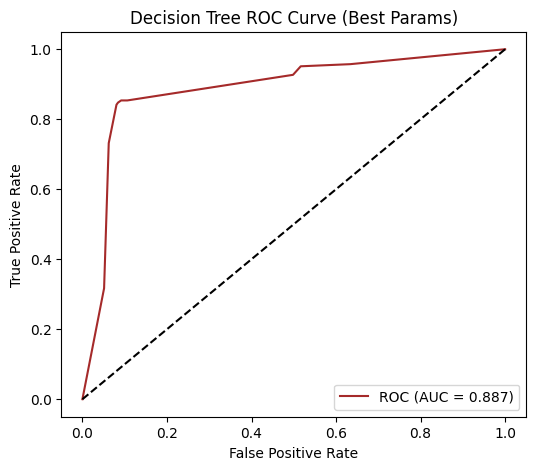

In [ ]:
# --- Hyperparams to explore ---
criteria = ["gini", "entropy"]
depths = [None, 5, 10]

def evaluate_dt(X_train, X_test, y_train, y_test,
                criterion, depth, use_pca=False):
    if use_pca:
        pca = PCA(n_components=0.95)
        X_train_proc = pca.fit_transform(X_train)
        X_test_proc = pca.transform(X_test)
    else:
        X_train_proc, X_test_proc = X_train, X_test

    model = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=depth,
        random_state=42
    )
    model.fit(X_train_proc, y_train)
    y_pred = model.predict(X_test_proc)
    y_prob = model.predict_proba(X_test_proc)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    return acc, auc, y_prob

results = []
for c in criteria:
    for d in depths:
        acc_no_pca, auc_no_pca, _ = evaluate_dt(
            X_train, X_test, y_train, y_test,
            c, d, use_pca=False
        )
        acc_pca, auc_pca, _ = evaluate_dt(
            X_train, X_test, y_train, y_test,
            c, d, use_pca=True
        )
        results.append({
            "criterion": c,
            "max_depth": d,
            "Accuracy_no_PCA": acc_no_pca,
            "Accuracy_PCA": acc_pca
        })

results_df = pd.DataFrame(results)
print("Decision Tree Performance Table")
print(results_df)

# --- Best by no-PCA accuracy ---
best_idx = results_df['Accuracy_no_PCA'].idxmax()
best_params = results_df.iloc[best_idx]
print("\nBest Decision Tree Params (No PCA)")
print(best_params)

# --- ROC curve for best combo ---
best_c = best_params['criterion']
best_d = best_params['max_depth']

# convert NaN to None, otherwise to int
if pd.isna(best_d):
    best_d = None
else:
    best_d = int(best_d)

dt_best = DecisionTreeClassifier(
    criterion=best_params['criterion'],
    max_depth=best_d,
    random_state=42
)
dt_best.fit(X_train, y_train)
y_proba_best = dt_best.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = roc_auc_score(y_test, y_proba_best)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})', color='brown')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve (Best Params)')
plt.legend(loc='lower right')
plt.show()

**Random Forest**

Random Forest Performance Table
   n_estimators  max_depth  Accuracy_no_PCA  Accuracy_PCA
0            50        NaN         0.922197      0.906178
1            50        5.0         0.910755      0.897025
2            50       10.0         0.924485      0.908467
3           100        NaN         0.924485      0.908467
4           100        5.0         0.908467      0.899314
5           100       10.0         0.922197      0.910755

Best Random Forest Params (No PCA)
n_estimators       50.000000
max_depth          10.000000
Accuracy_no_PCA     0.924485
Accuracy_PCA        0.908467
Name: 2, dtype: float64


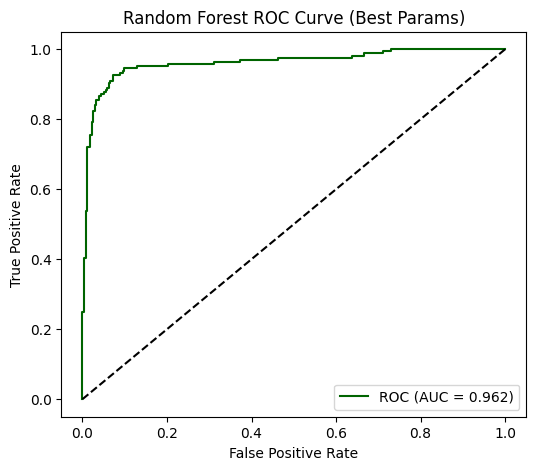

In [ ]:
# --- Hyperparams to explore ---
n_estimators_list = [50, 100]
max_depth_list = [None, 5, 10]

def evaluate_rf(X_train, X_test, y_train, y_test,
                n_estimators, depth, use_pca=False):
    if use_pca:
        pca = PCA(n_components=0.95)
        X_train_proc = pca.fit_transform(X_train)
        X_test_proc = pca.transform(X_test)
    else:
        X_train_proc, X_test_proc = X_train, X_test

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=depth,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_proc, y_train)
    y_pred = model.predict(X_test_proc)
    y_prob = model.predict_proba(X_test_proc)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    return acc, auc, y_prob

results = []
for n in n_estimators_list:
    for d in max_depth_list:
        acc_no_pca, auc_no_pca, _ = evaluate_rf(
            X_train, X_test, y_train, y_test,
            n, d, use_pca=False
        )
        acc_pca, auc_pca, _ = evaluate_rf(
            X_train, X_test, y_train, y_test,
            n, d, use_pca=True
        )
        results.append({
            "n_estimators": n,
            "max_depth": d,
            "Accuracy_no_PCA": acc_no_pca,
            "Accuracy_PCA": acc_pca
        })

results_df = pd.DataFrame(results)
print("Random Forest Performance Table")
print(results_df)

# --- Best by no-PCA accuracy ---
best_idx = results_df['Accuracy_no_PCA'].idxmax()
best_params = results_df.iloc[best_idx]
print("\nBest Random Forest Params (No PCA)")
print(best_params)

# --- Fix dtype for max_depth ---
best_depth = best_params['max_depth']
if pd.isna(best_depth):
    best_depth = None
else:
    best_depth = int(best_depth)

# --- ROC curve for best combo ---
rf_best = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=best_depth,
    random_state=42,
    n_jobs=-1
)
rf_best.fit(X_train, y_train)
y_proba_best = rf_best.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = roc_auc_score(y_test, y_proba_best)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})', color='darkgreen')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve (Best Params)')
plt.legend(loc='lower right')
plt.show()

**AdaBoost**

AdaBoost Performance
   n_estimators  learning_rate  Accuracy_no_PCA  Accuracy_PCA
0            50           0.01         0.821510      0.878719
1            50           0.10         0.897025      0.878719
2            50           1.00         0.908467      0.892449
3           100           0.01         0.844394      0.878719
4           100           0.10         0.899314      0.883295
5           100           1.00         0.915332      0.901602

Best Params (No PCA)
n_estimators       100.000000
learning_rate        1.000000
Accuracy_no_PCA      0.915332
Accuracy_PCA         0.901602
Name: 5, dtype: float64


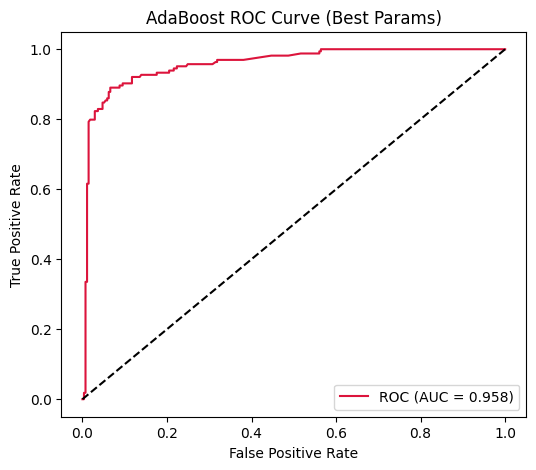

In [ ]:
# --- Hyperparam grids ---
n_estimators_list = [50, 100]
learning_rates = [0.01, 0.1, 1.0]

def eval_adaboost(X_train, X_test, y_train, y_test,
                  n_est, lr, use_pca=False):
    if use_pca:
        pca = PCA(n_components=0.95)
        X_train_proc = pca.fit_transform(X_train)
        X_test_proc = pca.transform(X_test)
    else:
        X_train_proc, X_test_proc = X_train, X_test

    model = AdaBoostClassifier(
        n_estimators=n_est,
        learning_rate=lr,
        random_state=42
    )
    model.fit(X_train_proc, y_train)
    y_pred = model.predict(X_test_proc)
    y_prob = model.predict_proba(X_test_proc)[:, 1]
    return (
        accuracy_score(y_test, y_pred),
        roc_auc_score(y_test, y_prob)
    )

results = []
for n in n_estimators_list:
    for lr in learning_rates:
        acc_no_pca, _ = eval_adaboost(X_train, X_test, y_train, y_test,
                                      n, lr, use_pca=False)
        acc_pca, _ = eval_adaboost(X_train, X_test, y_train, y_test,
                                   n, lr, use_pca=True)
        results.append({
            "n_estimators": n,
            "learning_rate": lr,
            "Accuracy_no_PCA": acc_no_pca,
            "Accuracy_PCA": acc_pca
        })

results_df = pd.DataFrame(results)
print("AdaBoost Performance")
print(results_df)

# --- Best combo (no PCA) ---
best_idx = results_df['Accuracy_no_PCA'].idxmax()
best_row = results_df.iloc[best_idx]
print("\nBest Params (No PCA)")
print(best_row)

# --- ROC for the best ---
best_model = AdaBoostClassifier(
    n_estimators=int(best_row['n_estimators']),
    learning_rate=float(best_row['learning_rate']),
    random_state=42
)
best_model.fit(X_train, y_train)
y_best_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_best_prob)
roc_auc = roc_auc_score(y_test, y_best_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})', color='crimson')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost ROC Curve (Best Params)')
plt.legend(loc='lower right')
plt.show()

**Gradient Boosting**

Gradient Boosting Performance
   n_estimators  learning_rate  Accuracy_no_PCA  Accuracy_PCA
0            50            0.1         0.924485      0.901602
1            50            0.2         0.922197      0.913043
2           100            0.1         0.931350      0.908467
3           100            0.2         0.929062      0.913043
4           200            0.1         0.924485      0.908467
5           200            0.2         0.931350      0.910755

Best Params (No PCA)
n_estimators       100.000000
learning_rate        0.100000
Accuracy_no_PCA      0.931350
Accuracy_PCA         0.908467
Name: 2, dtype: float64


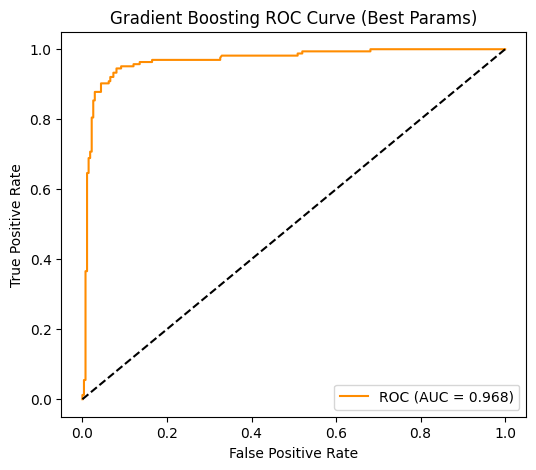

In [ ]:
# --- Hyperparam grids ---
n_estimators_list = [50, 100, 200]
learning_rates = [0.1, 0.2]

def eval_gb(X_train, X_test, y_train, y_test, n_est, lr, use_pca=False):
    if use_pca:
        pca = PCA(n_components=0.95)
        X_train_proc = pca.fit_transform(X_train)
        X_test_proc = pca.transform(X_test)
    else:
        X_train_proc, X_test_proc = X_train, X_test

    model = GradientBoostingClassifier(
        n_estimators=n_est,
        learning_rate=lr,
        random_state=42
    )
    model.fit(X_train_proc, y_train)
    y_pred = model.predict(X_test_proc)
    y_prob = model.predict_proba(X_test_proc)[:, 1]
    return accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_prob)

# Collect results
results = []
for n in n_estimators_list:
    for lr in learning_rates:
        acc_no_pca, _ = eval_gb(X_train, X_test, y_train, y_test,
                                n, lr, use_pca=False)
        acc_pca, _ = eval_gb(X_train, X_test, y_train, y_test,
                             n, lr, use_pca=True)
        results.append({
            "n_estimators": n,
            "learning_rate": lr,
            "Accuracy_no_PCA": acc_no_pca,
            "Accuracy_PCA": acc_pca
        })

results_df = pd.DataFrame(results)
print("Gradient Boosting Performance")
print(results_df)

# --- Best combo (no PCA) ---
best_idx = results_df['Accuracy_no_PCA'].idxmax()
best_row = results_df.iloc[best_idx]
print("\nBest Params (No PCA)")
print(best_row)

# --- ROC curve for best model ---
best_model = GradientBoostingClassifier(
    n_estimators=int(best_row["n_estimators"]),
    learning_rate=float(best_row["learning_rate"]),
    random_state=42
)
best_model.fit(X_train, y_train)
y_best_prob = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_best_prob)
roc_auc = roc_auc_score(y_test, y_best_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})', color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting ROC Curve (Best Params)')
plt.legend(loc='lower right')
plt.show()

**XGBoost**

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:42:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:42:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:42:53] WARNING: /w

XGBoost Performance Table
   n_estimators  learning_rate  max_depth  Accuracy_no_PCA  Accuracy_PCA
0            50            0.1          5         0.929062      0.908467
1            50            0.1          7         0.933638      0.908467
2            50            0.2          5         0.926773      0.906178
3            50            0.2          7         0.938215      0.908467
4           100            0.1          5         0.926773      0.910755
5           100            0.1          7         0.940503      0.910755
6           100            0.2          5         0.926773      0.906178
7           100            0.2          7         0.933638      0.915332

Best Params (No PCA)
n_estimators       100.000000
learning_rate        0.100000
max_depth            7.000000
Accuracy_no_PCA      0.940503
Accuracy_PCA         0.910755
Name: 5, dtype: float64


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:43:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


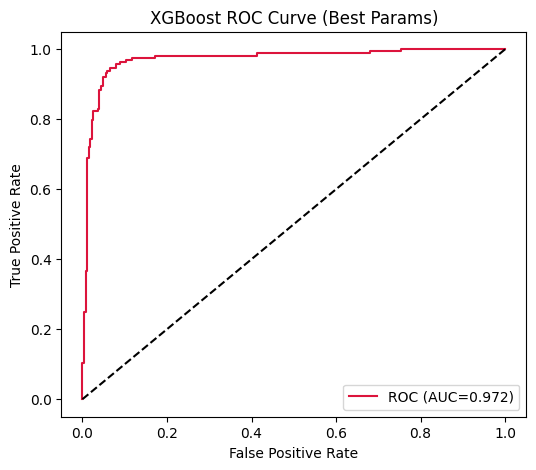

In [ ]:
# --- Hyperparam grids ---
n_estimators_list = [50, 100]
learning_rates   = [0.1, 0.2]
max_depths       = [5, 7]

def eval_xgb(X_train, X_test, y_train, y_test,
             n_est, lr, depth, use_pca=False):
    if use_pca:
        pca = PCA(n_components=0.95)
        X_train_proc = pca.fit_transform(X_train)
        X_test_proc  = pca.transform(X_test)
    else:
        X_train_proc, X_test_proc = X_train, X_test

    model = XGBClassifier(
        n_estimators=n_est,
        learning_rate=lr,
        max_depth=depth,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )
    model.fit(X_train_proc, y_train)
    y_pred  = model.predict(X_test_proc)
    y_proba = model.predict_proba(X_test_proc)[:, 1]
    return accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_proba)

# Collect results
rows = []
for n in n_estimators_list:
    for lr in learning_rates:
        for d in max_depths:
            acc_no, _ = eval_xgb(X_train, X_test, y_train, y_test,
                                 n, lr, d, use_pca=False)
            acc_pca, _ = eval_xgb(X_train, X_test, y_train, y_test,
                                  n, lr, d, use_pca=True)
            rows.append({
                "n_estimators": n,
                "learning_rate": lr,
                "max_depth": d,
                "Accuracy_no_PCA": acc_no,
                "Accuracy_PCA": acc_pca
            })

results_df = pd.DataFrame(rows)
print("XGBoost Performance Table")
print(results_df)

# --- Best params (No PCA) ---
best_idx = results_df['Accuracy_no_PCA'].idxmax()
best_row = results_df.iloc[best_idx]
print("\nBest Params (No PCA)")
print(best_row)

# --- ROC curve for best model ---
best_model = XGBClassifier(
    n_estimators=int(best_row["n_estimators"]),
    learning_rate=float(best_row["learning_rate"]),
    max_depth=int(best_row["max_depth"]),
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
best_model.fit(X_train, y_train)
y_prob = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.3f})', color='crimson')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve (Best Params)')
plt.legend(loc='lower right')
plt.show()

**Stacking (base learners + meta-learner)**

Stacked Model Performance
             Model  Accuracy_no_PCA  Accuracy_PCA  AUC_no_PCA   AUC_PCA
0   SVM+NB+DT → LR         0.917620      0.913043    0.958009  0.957942
1   SVM+NB+DT → RF         0.892449      0.899314    0.938823  0.943212
2  SVM+DT+KNN → LR         0.919908      0.919908    0.960824  0.963080

Best Stack (no PCA): SVM+DT+KNN → LR


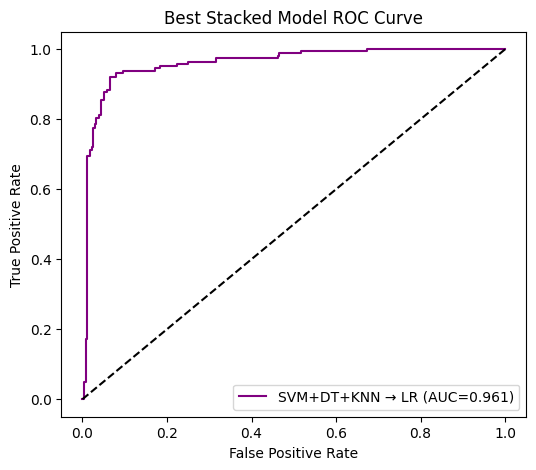

In [ ]:
# --- Base / final models ---
svm = SVC(kernel='linear', probability=True, random_state=42)
nb  = GaussianNB()
dt  = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier()

log_reg = LogisticRegression(max_iter=1000, random_state=42)
rf      = RandomForestClassifier(n_estimators=100, random_state=42)

# 3 stack varieties
stacks = {
    "SVM+NB+DT → LR": StackingClassifier(
        estimators=[('svm', svm), ('nb', nb), ('dt', dt)],
        final_estimator=log_reg, passthrough=False, n_jobs=-1
    ),
    "SVM+NB+DT → RF": StackingClassifier(
        estimators=[('svm', svm), ('nb', nb), ('dt', dt)],
        final_estimator=rf, passthrough=False, n_jobs=-1
    ),
    "SVM+DT+KNN → LR": StackingClassifier(
        estimators=[('svm', svm), ('dt', dt), ('knn', knn)],
        final_estimator=log_reg, passthrough=False, n_jobs=-1
    )
}

def eval_stack(model, use_pca=False):
    if use_pca:
        pca = PCA(n_components=0.95)
        Xtr = pca.fit_transform(X_train)
        Xte = pca.transform(X_test)
    else:
        Xtr, Xte = X_train, X_test
    model.fit(Xtr, y_train)
    y_pred  = model.predict(Xte)
    y_prob  = model.predict_proba(Xte)[:, 1]
    return accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_prob), y_prob

results = []
roc_curves = {}

for name, model in stacks.items():
    acc_no, auc_no, prob_no = eval_stack(model, use_pca=False)
    acc_pca, auc_pca, prob_pca = eval_stack(model, use_pca=True)
    results.append({
        "Model": name,
        "Accuracy_no_PCA": acc_no,
        "Accuracy_PCA": acc_pca,
        "AUC_no_PCA": auc_no,
        "AUC_PCA": auc_pca
    })
    roc_curves[name] = (prob_no, auc_no)

results_df = pd.DataFrame(results)
print("Stacked Model Performance")
print(results_df)

# Plot ROC of the best one (by AUC_no_PCA)
best_idx = results_df['AUC_no_PCA'].idxmax()
best_name = results_df.loc[best_idx, 'Model']
print("\nBest Stack (no PCA):", best_name)

best_probs = roc_curves[best_name][0]
fpr, tpr, _ = roc_curve(y_test, best_probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='purple',
         label=f"{best_name} (AUC={roc_curves[best_name][1]:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Best Stacked Model ROC Curve')
plt.legend()
plt.show()

**5-Fold Cross-Validation**

In [ ]:
# --- Base estimators for stack ---
svm = SVC(kernel='linear', C=0.1, gamma='scale', probability=True, random_state=42)
nb  = GaussianNB(var_smoothing=1e-7)
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='euclidean')
logr= LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
dt  = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)
rf  = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
ab  = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)
gb  = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=7,
                    eval_metric='logloss', use_label_encoder=False, random_state=42)
stack = StackingClassifier(
    estimators=[('svm', svm), ('dt', dt), ('knn', knn)],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_jobs=-1
)

models = {
    "SVM": svm,
    "Naive Bayes": nb,
    "KNN": knn,
    "Logistic Regression": logr,
    "Decision Tree": dt,
    "Random Forest": rf,
    "AdaBoost": ab,
    "Gradient Boosting": gb,
    "XGBoost": xgb,
    "Stacked": stack
}

# === Cross-validation setup ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_scores(model, X, y):
    return cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)

# PCA transform once
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# === Run CV ===
rows = []
for name, model in models.items():
    scores_no = cv_scores(model, X_scaled, y)
    scores_pca = cv_scores(model, X_pca, y)
    row = {"Model": name}
    for i, s in enumerate(scores_no, start=1):
        row[f"Fold{i}"] = round(s, 4)
    row["Avg (No PCA)"]  = round(scores_no.mean(), 4)
    row["Avg (With PCA)"] = round(scores_pca.mean(), 4)
    rows.append(row)

cv_results = pd.DataFrame(rows)

# make sure all fold columns exist
for f in range(1, 6):
    if f"Fold{f}" not in cv_results.columns:
        cv_results[f"Fold{f}"] = np.nan

print("5-Fold Cross-Validation Results")
print(cv_results[
    ["Model","Fold1","Fold2","Fold3","Fold4","Fold5","Avg (No PCA)","Avg (With PCA)"]
].sort_values("Avg (No PCA)", ascending=False))

5-Fold Cross-Validation Results
                 Model   Fold1   Fold2   Fold3   Fold4   Fold5  Avg (No PCA)  \
8              XGBoost  0.9405  0.9268  0.9497  0.9519  0.9634        0.9465   
5        Random Forest  0.9291  0.9108  0.9451  0.9405  0.9519        0.9355   
7    Gradient Boosting  0.9199  0.9176  0.9451  0.9359  0.9519        0.9341   
9              Stacked  0.9176  0.9108  0.9382  0.9336  0.9359        0.9272   
6             AdaBoost  0.9085  0.9130  0.9291  0.9314  0.9291        0.9222   
3  Logistic Regression  0.9153  0.8947  0.9291  0.9336  0.9336        0.9213   
0                  SVM  0.9153  0.9016  0.9268  0.9314  0.9222        0.9195   
2                  KNN  0.9085  0.9016  0.9291  0.9108  0.8879        0.9076   
4        Decision Tree  0.8970  0.8810  0.9176  0.9153  0.8810        0.8984   
1          Naive Bayes  0.7323  0.7368  0.7506  0.7254  0.7735        0.7437   

   Avg (With PCA)  
8          0.9263  
5          0.9195  
7          0.9227  
9      

In [ ]:
# === Final Train/Test Scoreboard ===
rows = []
for name, model in models.items():
    model.fit(X_train, y_train)

    train_acc = model.score(X_train, y_train)
    test_acc  = model.score(X_test,  y_test)

    rows.append({
        "Model": name,
        "Train Accuracy": round(train_acc, 4),
        "Test Accuracy":  round(test_acc, 4)
    })

final_scores = pd.DataFrame(rows).sort_values("Test Accuracy", ascending=False)

print("\nTrain vs Test Accuracy (Full Train Fit)")
print(final_scores.reset_index(drop=True))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:13:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Train vs Test Accuracy (Full Train Fit)
                 Model  Train Accuracy  Test Accuracy
0              XGBoost          0.9931         0.9405
1    Gradient Boosting          0.9771         0.9314
2        Random Forest          0.9760         0.9245
3              Stacked          0.9811         0.9153
4             AdaBoost          0.9394         0.9153
5  Logistic Regression          0.9308         0.9153
6                  KNN          1.0000         0.9108
7                  SVM          0.9331         0.9108
8        Decision Tree          0.9725         0.8902
9          Naive Bayes          0.7586         0.7254
